# Use redis as a Vector database

If you want to see a tutorial about how to do this see:
 [Redis as a vector database](https://sefiks.com/2023/07/13/redis-as-a-vector-database-fast-vector-similarity-search-with-redisearch/)

We are going to use a face recognition technology to extract faces from images. The 
library choosed [DeepFace](https://github.com/serengil/deepface) can do all the [stage tasks](https://sefiks.com/2020/05/01/a-gentle-introduction-to-face-recognition-in-deep-learning/) 
at once. 
The library is particularly interesting because it implement several detectors and models using the 
same interface. So, you can test the best convination for your particular use case.


I recommend the author [blog](https://sefiks.com/) site if you want to know more about computer vision and face recognition.

At the end, We are just going to use the method to extract the face representation vectors in the image picture.

For understandig the concepts have a look at a the following [pdf](https://redis.com/wp-content/uploads/2023/04/vss-cheat-sheet.pdf)

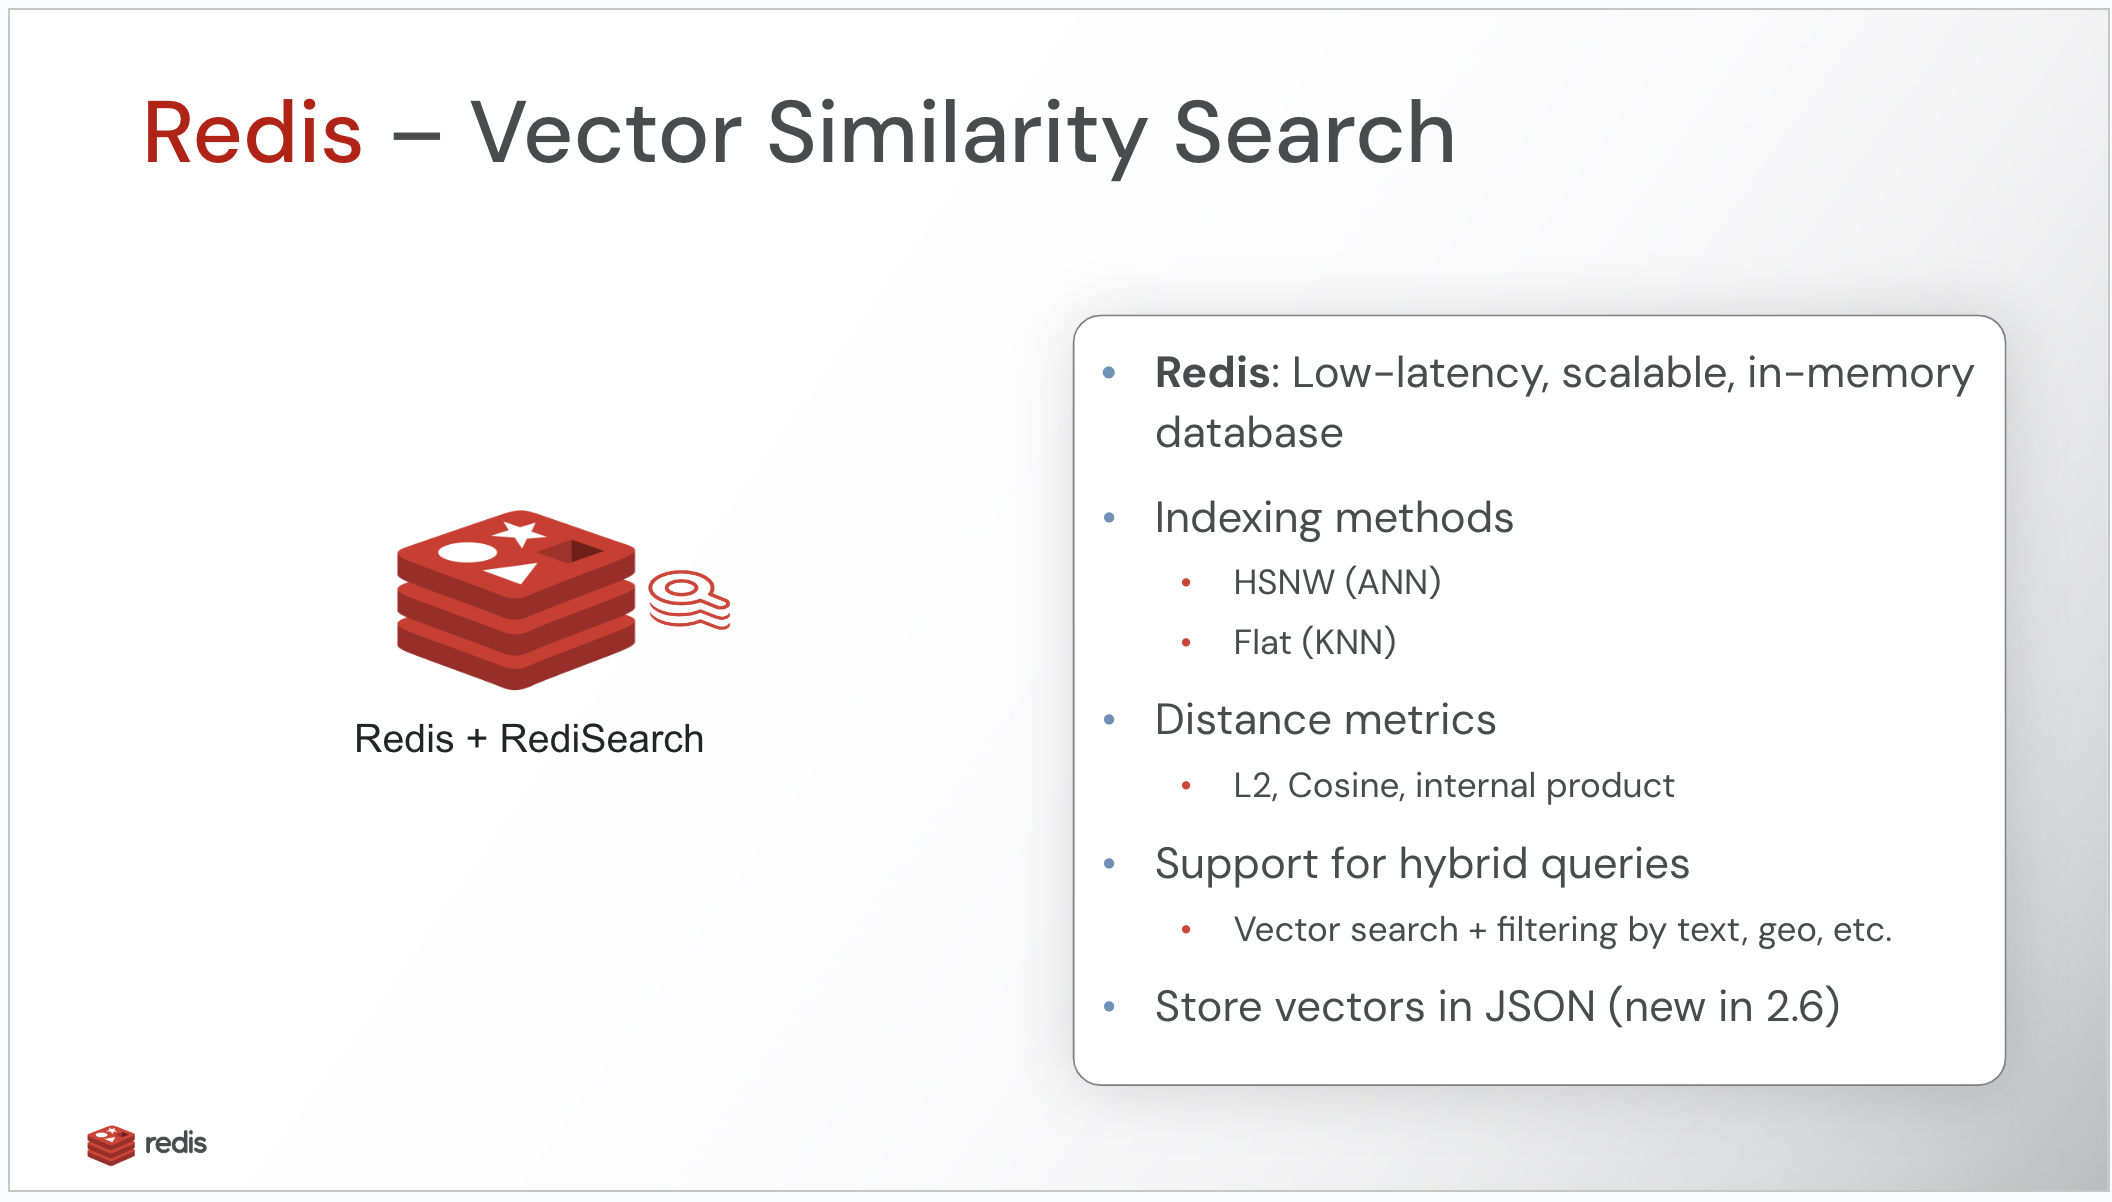

In [ ]:
# !pip install redis tqdm ipython deepface
import redis
from redis.commands.search.indexDefinition import IndexDefinition, IndexType
from redis.commands.search import field
from redis.commands.search.query import Query

import os
import zlib
from tqdm import tqdm

import numpy as np
from deepface import DeepFace

import cv2
from PIL import Image
from IPython.display import display



Now we are going to connect to redis. I am using redis on localhost. To install it follow the instructions to [run redis enterprise on docker](https://docs.redis.com/latest/rs/installing-upgrading/quickstarts/docker-quickstart/):

And also define some defaults:

- Normalization
    - Model to use for extracting the face from the picture and aligned it, so it pesent the face right even if the face is tilted.
    - Option list: 'base', 'raw', 'Facenet', 'Facenet2018', 'VGGFace', 'VGGFace2', 'ArcFace'
- Detector:
    - CNN Model to use
    - Option list: "opencv", "ssd", "dlib", "mtcnn", "retinaface", "mediapipe", "yolov8", "yunet"
- Model:
    - CNN Model to use
    - Option list: 'VGG-Face', 'Facenet', 'Facenet512', 'ArcFace', 'Dlib', 'SFace', 'OpenFace', 'DeepFace', 'DeepID'

Then there is a list of names for the different possible distance calculation algorithms and Index types.



In [ ]:
r = redis.Redis(host = "localhost", port = 6379)
 
model_name = "Facenet512"
#model_name = "ArcFace"
detector_backend = "retinaface"
#normalization = "Facenet"

flat_l2 = "faces_flat_l2"
hnsw_l2 = "faces_hnsw_l2"
flat_cosine="faces_flat_cosine"
hnsw_cosine="faces_hnsw_cosine"
indexes = [flat_l2, hnsw_l2, flat_cosine, hnsw_cosine]


In [ ]:
r.flushdb()


Now we are going to walk thru all the pictures in the camera directory and extract all faces using DeepFace. 

We will store each embedding in a redis hash with the name of the fille, and the facial area coordinates. 
Each entry will have a  key generated using a crc32 value o the image name and the face number in the picture.

This step will take a few minutes, arround 5 in mi Silicon Mac. Remember I am using a tensorflow compilation that can 
leverage the use of the GPU. Have a look at the READM to see how to install it if you are on a Silicon Mac.

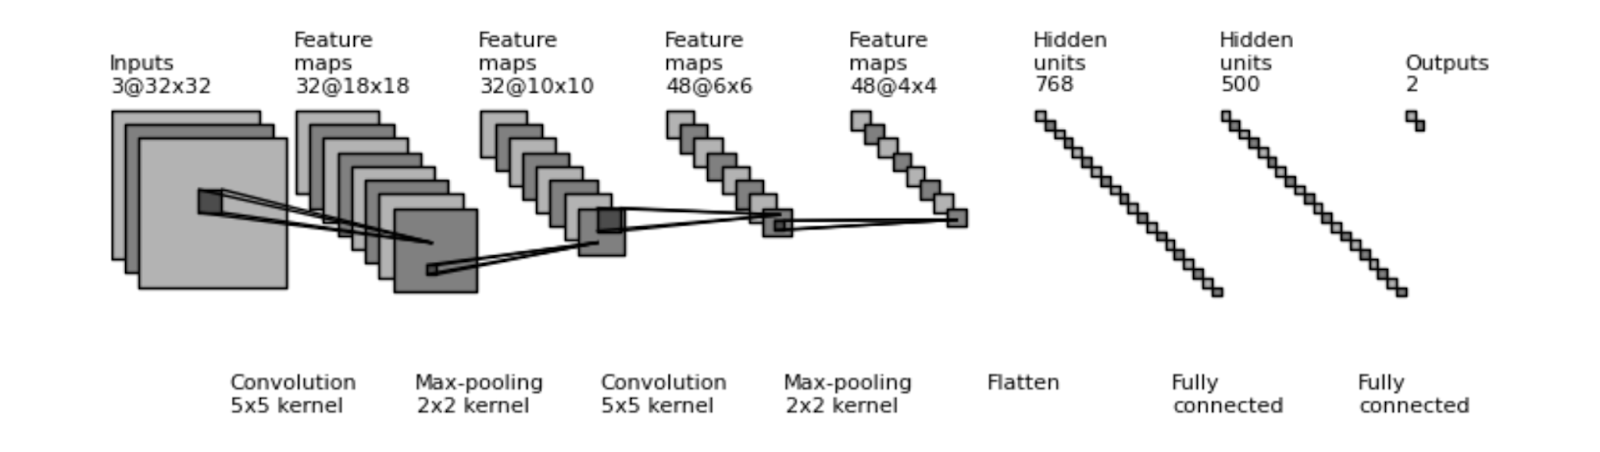
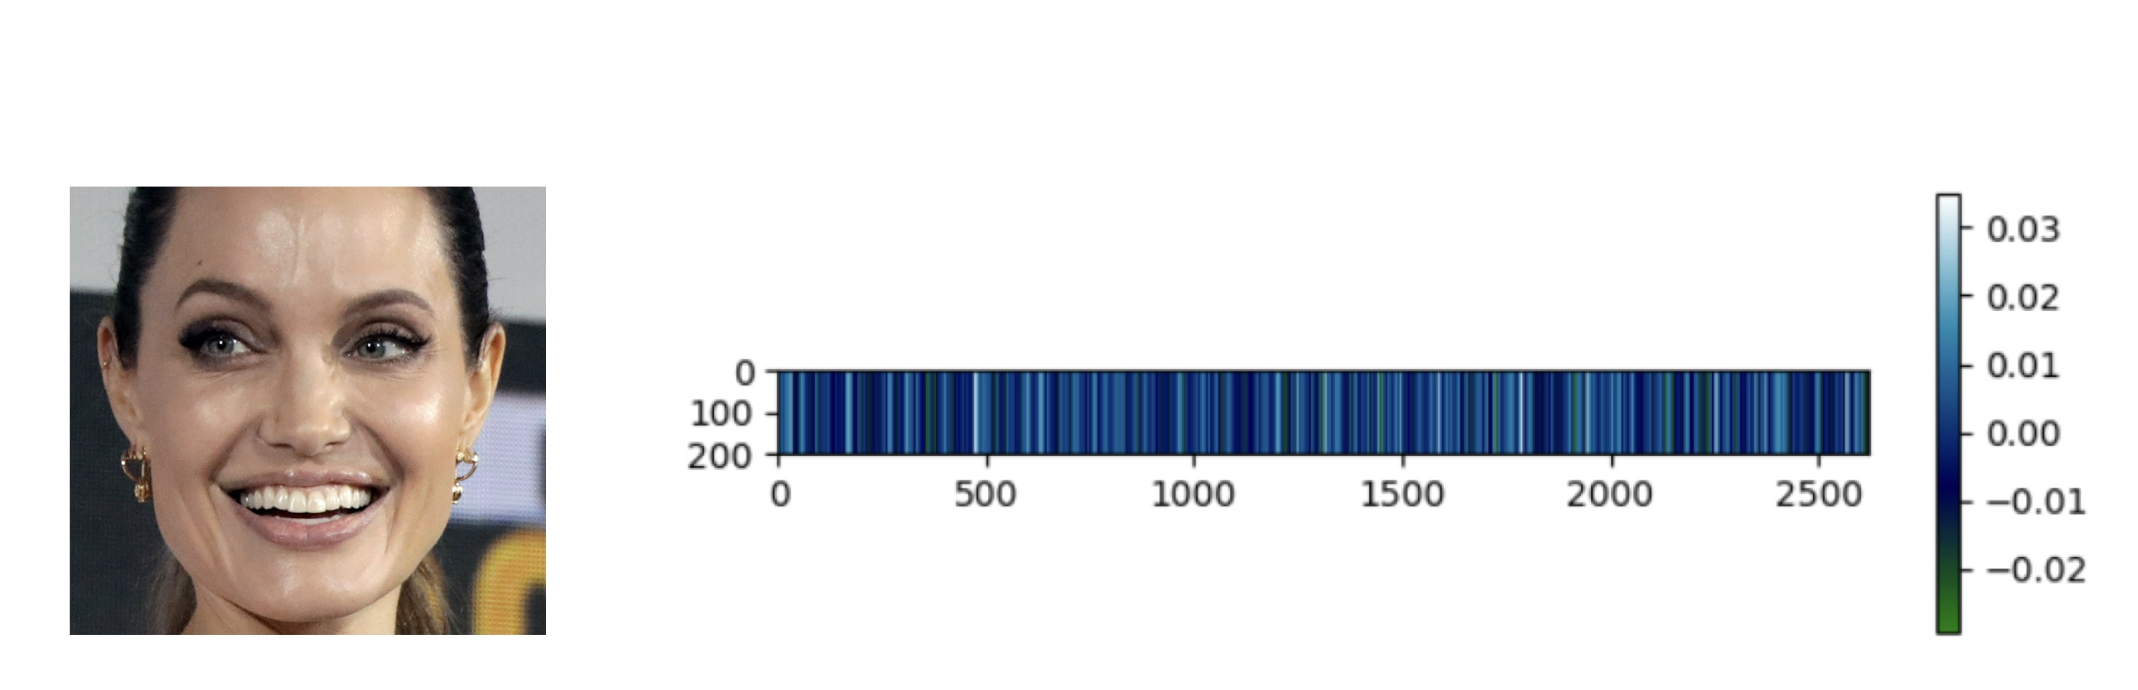

In [ ]:
faces_num = 0
images_with_faces = []
images_without_faces = []

for dirpath, dirnames, filenames in os.walk("./photos/Oscars2022_MTV2023/"):
    for filename in tqdm(filenames):
        pipeline = r.pipeline(transaction=False)
        #if ".jp" in filename:
        img_path = os.path.join(dirpath, filename)
        try:
            imgs = DeepFace.represent(
                img_path,
                model_name=model_name,
                detector_backend=detector_backend)
            
            for i, img in enumerate(imgs):
                key = "faces:" + hex(zlib.crc32(bytes(filename + str(i), "UTF-8")) & 0xFFFFFFFF)
                embedding = img['embedding']
                value = np.array(embedding).astype(np.float32).tobytes()
                pipeline.hset(key, mapping = {
                    "image": img_path, 
                    "embedding": value,
                    "face_x": img["facial_area"]["x"],
                    "face_y": img["facial_area"]["y"],
                    "face_w": img["facial_area"]["w"],
                    "face_h": img["facial_area"]["h"],})

                faces_num = faces_num + 1
            
            images_with_faces.append(img_path)

            pipeline_results = pipeline.execute()
        except:
            images_without_faces.append(img_path)
            pass

print("Total faces: ", faces_num, " in ", len(images_with_faces), " images")
print("Total images with no faces: ", len(images_without_faces))

Now that the redis hash is populated we are ready to create the four indexes. 
Combining [flat, hnsw](https://redis.io/docs/interact/search-and-query/search/vectors/#making-the-bikes-collection-searchable) index types 
with cosene and l2 distance metrics.

If you want to learn about different distances types visit the post: [Different types of Distances used in Machine Learning Explained!](https://tuhinmukherjee74.medium.com/different-types-of-distances-used-in-machine-learning-explained-550e2979752c)

In [ ]:
# Flat Index
def create_flat_index(r, idx_name, prefix, vector_field_name, vector_dimensions=512, distance_metric='L2'):
  try:
    r.ft(idx_name).dropindex()
  except:
    pass
    #print("Index does not exists!")
  schema = (
      field.VectorField(vector_field_name, "FLAT", {
         "TYPE": "FLOAT32", 
         "DIM": vector_dimensions, 
         "DISTANCE_METRIC": distance_metric, 
      }),
  )

  r.ft(idx_name).create_index(schema, definition=IndexDefinition(prefix=[prefix], index_type=IndexType.HASH))    

# Hierarchical Navigable Small Worlds (HNSW)
def create_hnsw_index(r, idx_name, prefix, vector_field_name, vector_dimensions=512, distance_metric='L2', M=40, EF=200):
  try:
    r.ft(idx_name).dropindex()
  except:
    pass

  schema = (
    field.VectorField(vector_field_name, "HNSW", {
         "TYPE": "FLOAT32",
         "DIM": vector_dimensions, 
         "DISTANCE_METRIC": distance_metric, 
         "M": M, 
         "EF_CONSTRUCTION": EF}),
  )

  r.ft(idx_name).create_index(schema, definition=IndexDefinition(prefix=[prefix], index_type=IndexType.HASH))    

prefix = "faces:"
create_flat_index(r, flat_l2, prefix, "embedding")
create_hnsw_index(r, hnsw_l2, prefix, "embedding")
create_flat_index(r, flat_cosine, prefix, "embedding", distance_metric="COSINE")
create_flat_index(r, hnsw_cosine, prefix, "embedding", distance_metric="COSINE")


The next functions is used to show an image: it scales it to 'width' and paint an suare arround the face described at 'facial_area'.

In [ ]:
def show_image(image_path, facial_area=None, width=400):
    img = cv2.imread(image_path)

    # Square arreound face
    if facial_area:
        a = facial_area
        img = cv2.rectangle(img, (a['x'], a['y']), (a['x']+a['w'], a['y']+a['h']), (0, 255, 0), 4)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
    
    # Resize
    (original_height, original_width) = img.shape[:2]
    ratio = width / original_width
    height = int(original_height * ratio)
    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_AREA)

    # o = DeepFace.analyze(img_path = image_path, detector_backend=detector)[0]
    # print(f"A {o['dominant_emotion']} {o['age']} years old {o['dominant_race']} {o['dominant_gender']}")
    
    display(Image.fromarray(img))

We now choose the person to look for in the pictures. Create the embedding and show the image

In [ ]:
#target_image = ["photos/Celebrities/Cate_Blanchett/Cate_Blanchett.jpg", 1]
target_image = ["photos/Celebrities/Angelina_Jolie/Angelina_Jolie.jpg", 0]
#target_image = ["photos/Celebrities/Brendan_Fraser/Brendan_Fraser.jpg", 0]
#target_image = ["photos/Celebrities/Cara_Delevigne/Cara_Delevigne.webp", 0]
#target_image = ["photos/Celebrities/Shakira/Shakira.png", 0]
#target_image = ["photos/Celebrities/Taylor_Swift/Taylor_Swift.png", 0]

file, idx = target_image
print(file, idx)

target = DeepFace.represent(
    img_path=file,
    model_name=model_name,
    detector_backend=detector_backend)[idx]

target_embedding = target["embedding"] 
query_vector = np.array(target_embedding).astype(np.float32).tobytes()

print("Looking for faces of:")
show_image(file, target['facial_area'])

And now the magic!!
Look for the face using vector similarity search in our redis database...

In [ ]:
def findThreshold(metric):
   if metric == 'cosine':
      return 0.50
      #return 0.6871912959056619
   elif metric == 'euclidean':
      return 4.1591468986978075
   elif metric == 'euclidean_l2':
      return 1.1315718048269017
   
def search_images_precission(r, index_name, query_vector, radius, first, max):
    base_query = "@embedding:[VECTOR_RANGE $radius $query_vector]=>{$YIELD_DISTANCE_AS: distance}"
    query = Query(base_query).dialect(2).sort_by("distance").paging(first, max)
    query_params = {"radius":radius, "query_vector": query_vector}
    results = r.ft(index_name).search(query, query_params=query_params)

    print("="*60)
    print(index_name, ":Encontradas ", len(results.docs), " images!")
    print("="*60)
    return results

max = 25 # Results to return
#res = search_images_precission(r, hnsw_l2, query_vector, findThreshold("euclidean_l2"), 0, max)
#res = search_images_precission(r, flat_l2, query_vector, findThreshold("euclidean_l2"), 0, max)
#res = search_images_precission(r, hnsw_cosine, query_vector, findThreshold("cosine"), 0, max)
res = search_images_precission(r, flat_cosine, query_vector, findThreshold("cosine"), 0, max)

for idx, result in enumerate(res.docs):
    print(f"({idx}) {result.image}: {result.distance}")
    facial_area = {
       "x": int(result.face_x), "y": int(result.face_y),
       "w": int(result.face_w), "h": int(result.face_h)
    }
    show_image(result.image, facial_area)

# Real Time detection
1. Create a database of faces, including mine. I dowload the database from [here][(https://vis-www.cs.umass.edu/lfw/).
2. Add my face to the faces database
3. Walk all the pictures, get the image embedding and add it to redis


In [ ]:
import glob

model_name = "Facenet512"
detector_backend = "mediapipe"

prev_person = "" # Trick to read only one pic from each person
faces_num = 0
for img_path in tqdm(glob.glob("photos/Celebrities/*/*")):
    person = img_path.split("/")[2]
    if person != prev_person:
        try:
            img = DeepFace.represent(
                img_path,
                model_name=model_name,
                detector_backend=detector_backend)[0]
            
            key = "lfw:" + person
            embedding = img['embedding']
            value = np.array(embedding).astype(np.float32).tobytes()
            r.hset(key, mapping = {
                "embedding": value,
                "name": person,
                "face_x": img["facial_area"]["x"],
                "face_y": img["facial_area"]["y"],
                "face_w": img["facial_area"]["w"],
                "face_h": img["facial_area"]["h"],})

            faces_num = faces_num + 1
            
            prev_person = person
        except Exception as e:
            print(person, e)
            pass
print("Dimensions", len(img['embedding']))
print("Total faces: ", faces_num)

Now we need to create the redis vss index

In [ ]:
prefix = "lfw:"
lfw_index_name = "lfw_flat_cosine"
create_flat_index(r, lfw_index_name, prefix, "embedding", distance_metric="COSINE")

In [ ]:
import numpy as np
import cv2
from deepface import DeepFace

# Webcam
#cap = cv2.VideoCapture(0)
width, height = 640, 480
#cap.set(3, width) # set Width
#cap.set(4, height) # set Height

# File
#cap = cv2.VideoCapture("photos/Oscar_Mejor_Actor_2022.mp4")
cap = cv2.VideoCapture("photos/Recortado.mp4")
width, height = 640, 360

print(f"Model: {model_name} Detector: {detector_backend}")
while(True):
    ret, frame = cap.read()
    if not ret:
        break

    #frame = cv2.resize(frame, (width, height))
    try:
        faces = DeepFace.represent(
            frame,
            model_name=model_name,
            detector_backend=detector_backend)
        
        for face in faces:
            query_vector = np.array(face["embedding"]).astype(np.float32).tobytes()
            query = (
                Query("*=>[KNN 1 @embedding $vec as score]")
                .sort_by("score")
                .return_fields("name", "score")
                .paging(0, 1)
                .dialect(2)
            )
            query_params = {"vec": query_vector,}
            res = r.ft(lfw_index_name).search(query, query_params)
            #if doc.score > 6.0:
            #    continue

            a = face['facial_area']
            cv2.rectangle(frame, (a['x'], a['y']), (a['x']+a['w'], a['y']+a['h']), (0, 255, 0), 4)
            #print(res)
            doc = res.docs[0]
            #print(doc)

            cv2.putText(frame, f"{doc.name} - {doc.score}", (a['x'], a['y']-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 1, cv2.LINE_AA)
    except Exception as e:
        #print(e)
        pass

    cv2.imshow('frame', frame)
    
    k = cv2.waitKey(30) & 0xff
    if k == 27: # press 'ESC' to quit
        break
cap.release()
cv2.destroyAllWindows()

Now we create the vector for the face in the picture selected. We used this vector to serch in our redis database

At the end we do the vector similarity search in our redix index! 